In [254]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
from sklearn import preprocessing
import matplotlib.ticker as ticker
%matplotlib inline
style.use('ggplot')

<h1><center> Reuse in Software Repositories and its effect on Quality and Usage</center></h1>

The aim:
To evaluate whether there are relations between the reuse score and the quality & usage score

## Helper functions

In [255]:
BINS_AMOUNT = 10

In [256]:
# counts "issues" from the "issues" csv and merges the count as a new column into the main repo_csv file
def merge_issues(domain_name, repo_csv, issues_csv):
    # load the main repository csv
    df_repos = pd.read_csv("raw_tables/"+repo_csv)

    # Get issues from the issues csv
    df_issues = pd.read_csv("raw_tables/"+issues_csv)
    series = df_issues["repo_id"].value_counts()
    df_issue_counter = pd.DataFrame({"repo_id":series.index,"issues":series.values})

    # merge the issues to together with the main repository csv.
    # repos which don't exist in the issues csv are filled with 0 issues
    df_repos_merged = df_repos.merge(df_issue_counter,on="repo_id",how="left").fillna(0,downcast='infer')

    # write csv
    df_repos_merged.to_excel(domain_name+"_repositories.xlsx",index=False)

In [257]:
# calculates the similarity score based on the similarity matrix
def similarity_metric(values, bins_amount):
    bin_size = 100/bins_amount
    values = values.drop(values.name) # dropping the 100 from the project itself
    bins = np.arange(0,100+bin_size,bin_size)
    weights = np.arange(bin_size/2, 100+bin_size/2, bin_size)
    statistic, bin_edges, binnumber = stats.binned_statistic(values, values, 'count', bins)
    metric = sum(statistic*weights)/len(values)
    return round(metric,5)

In [258]:
def calculate_similarity_scores(df_similarity, bins):
    df_similarity["score"] = df_similarity.apply(similarity_metric, axis=1,bins_amount=bins)
    return df_similarity.sort_values(by="score",ascending=False)

In [259]:
# forms a box plot and retrieves the *maximum value from a dataframe column
# we define maximum as the value at the top whisker in the box plot (IQR+Q3*1.5)
def max_metrics(df,columns):
    values = []
    for col in columns:
        dic = df.boxplot(column=col, return_type="dict", showfliers=False, whis=1.5);
        plt.close()
        top_whisker = dic["caps"][1].get_ydata()[0]
        ninth_quantile = df.quantile(0.9)[col]
        max_value = top_whisker if (top_whisker != 0) else ninth_quantile
        values.append(max_value)
    return values

In [260]:
#     maxForks, maxStargazers, maxWatchers, maxIssues = [df["forks_count"].max(),
#                                                        df["stargazers_count"].max(),
#                                                        df["subscribers_count"].max(),
#                                                       df["issues"].max()]

In [261]:
# calculates the quality score based on specific parameters in the quality csv
def calculate_quality_score(df):
    # calculate score
    columns = ["forks_count","stargazers_count","subscribers_count","issues"]
    maxForks, maxStargazers, maxWatchers, maxIssues = max_metrics(df, columns)
    print(maxForks, maxStargazers, maxWatchers, maxIssues)
    
    df["score"] =  df.apply(lambda row: row["stargazers_count"]*0.65/maxStargazers + 
                           row["forks_count"]*0.2/maxForks + row["watchers_count"]*0.05/maxWatchers + 
                           row["issues"]*0.05/maxIssues,axis=1)
    
    # we clip the final score at the 90% quantile - all scores above equal 100
    maxScore =  df.quantile(0.9)["score"]
    df["score"] = np.clip(df["score"],a_min=df["score"].min() ,a_max=maxScore)
    df["score"]= df["score"].round(3)
    
    #  normalize the score
    maxQuality = df["score"].max()
    minQuality = df["score"].min()
    df["score"] = df.apply(lambda row: (row["score"]-minQuality)/(maxQuality-minQuality)*100,axis=1)
    
    
    df["score"]= df["score"].round(5)
    return df.sort_values(by="score",ascending=False)

In [262]:
def combine_quality_similarity(df_similarity, df_quality):
    # treating df_similarity
    df_similarity_scores = df_similarity["score"].to_frame("similarity").reset_index()
    df_similarity_scores = df_similarity_scores.rename(columns={"index":"repo_id"})
    
    # treating df_quality_scores
    df_quality_scores = df_quality[["repo_id","score"]]
    df_quality_scores = df_quality_scores.rename(columns={"score":"quality"})

    df_combined = pd.merge(df_similarity_scores, df_quality_scores, how="inner", on="repo_id")
    df_combined = df_combined.set_index("repo_id")

    return df_combined


In [263]:
def plot_correlation(domain_name, df):
    sns.lmplot( x='similarity',y='quality',data=df,fit_reg=True,ci=None,
           aspect=1.8, line_kws={'color':'blue','alpha':0.6})
    plt.xlabel("similarity",fontsize=12)
    plt.ylabel("quality",fontsize=12)
    plt.title(f'{domain_name} Dataset - Quality vs Similarity',fontsize=15)
    plt.savefig(f'output/{domain_name} correlation.png', bbox_inches='tight')

In [264]:
def histogram(scores,title,face_color,text_offset,bins_amount=None):
    # plotting histogram
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_ylabel('Amount of repositories',size=14)
    ax.set_xlabel('Scores', size=14)
    n, bins, _ = ax.hist(scores, bins=bins_amount, facecolor=face_color,alpha=0.5,
                         edgecolor='black', linewidth=2)  
    ax.set_xticks(np.round(bins,2))

    ax.set_title(title, size=15)
    ax.tick_params(axis='both', which='major', labelsize=14)

    for index, value in zip(bins, n):
        ax.text(x=index+text_offset, y=value, s=f"{int(value):,}", 
                color='black', fontweight='bold',size=15);
    plt.savefig(f'output/{title}.png', bbox_inches='tight')
    plt.show()

In [300]:
def metric_boxplots(df, title):
    columns = ["forks_count","stargazers_count","subscribers_count","issues"]
    metrics = []
    for column in columns:
        metrics.append(df[column].values)
    fig,ax = plt.subplots(figsize=(12,10))

    ax.set_yscale('symlog')
    box_stats = ax.boxplot(metrics, labels=["forks_count","stargazers_count","watchers_count","issues"],
                           autorange=False, whis=2);
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x)))
    # ax.yaxis.set_major_formatter(FixedFormatter([0,10,50,100,200,300,400,500]))

    boxes = [whiskers.get_ydata()[0] for whiskers in box_stats["whiskers"]] # where 1st whisker ends & 2nd starts
    whiskers = [whiskers.get_ydata()[1] for whiskers in box_stats["caps"]]
    extreme_outliers = [np.sort(outlier.get_ydata())[-1] if
                        len(outlier.get_ydata())!=0 else 0 for outlier in box_stats["fliers"]]

    # create indexes for text creation
    indexes = np.arange(len(whiskers))
    indexes = np.repeat(indexes+1,2) # repeat index to enable the drawing of all data on each boxplot

    ax.tick_params(axis = 'both', which = 'major', labelsize = 13)
    # plot numbers on boxes
    for index, value in zip(indexes,boxes):
        ax.text(x=index-0.1, y=value, s=f"{int(value):}", color='blue', fontweight='bold', size=12);
    # plot numbers on boxes
    for index, value in list(zip(indexes,whiskers)):
        ax.text(x=index-0.1, y=value, s=f"{int(value):}", color='blue', size=12);
    # plot numbers on outliers
    for index, value in list(zip(np.arange(len(extreme_outliers))+1,extreme_outliers)):
        if value != 0:
            ax.text(x=index-0.1, y=value, s=f"{int(value):}", color='blue', size=12);
            
    ax.set_title(title, fontsize = 14)
    ax.set_xlabel("metrics")
    ax.set_ylabel("values (log scale)");
    plt.savefig(f'output/{title} metrics Boxplots.png', bbox_inches='tight')

In [266]:
def show_insignificants(df, dataset_name):
    df_insignificants = pd.DataFrame({"All row values are less than or equal to":[], "rows":[]}, index=None, dtype=int)
    columns = ["forks_count","stargazers_count","subscribers_count","issues"]
    for value in range(11):
        num_rows = len(df.loc[(df[columns]<=value).all(axis=1)][columns])
        df_insignificants.loc[len(df_insignificants)] = [value, num_rows]
    print(f'Total rows in the {dataset_name} dataset: {len(df)}')
    return df_insignificants

In [267]:
def similarity_scatter(df, title):
    fig, ax = plt.subplots(figsize=(16,9))
    iteration = 0
    df = df_similarity.sort_values(by="score").iloc[0:,:-1]
    for row in df.index:
        repo = df.loc[row].drop(df.loc[row].name) # row as a series
        index = np.full(shape=len(repo.values),fill_value=iteration,dtype=int)
        iteration = iteration + 1
        ax.scatter(index,repo.values,s=20)
        
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10.00))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(10.00))
    
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_title(f'{title} Dataset - Similarity Scores Scatter')
    ax.set_xlabel(f'repositories - Numbered from 0 to {len(df)}')
    ax.set_ylabel('scores')
    plt.savefig(f'output/{title} scatter.png', bbox_inches='tight')

## Issues merge
For each pair of repository.csv and issues.csv we've created a new combined.csv which contains the all of the information from the original repository.csv, in addition to a new column which holds the "issues" count per each repository, derived from the issues.csv.

In [ ]:
merge_issues(domain_name="tetrisgames",repo_csv="tetrisgames_github_table_repository.csv",
             issues_csv="tetrisgames_github_table_issues.csv")
merge_issues(domain_name="dbmanagement",repo_csv="dbmanagement_github_table_repository.csv",
             issues_csv="dbmanagement_github_table_issues.csv")
merge_issues(domain_name="operatingsystems",repo_csv="operatingsystems_github_table_repository.csv",
             issues_csv="operatingsystems_github_table_issues.csv")

## Tetris Games Dataset

### Similarity dataset

In [268]:
df_similarity = pd.read_excel("tetrisgames_similarity_matrix.xlsx",sheet_name=0,index_col=0)
df_similarity = calculate_similarity_scores(df_similarity,bins=BINS_AMOUNT) # calculate similarity
df_similarity

,MDEwOlJlcG9zaXRvcnk0MDA5ODIxOA==,MDEwOlJlcG9zaXRvcnk0MDYyMTg5Mg==,MDEwOlJlcG9zaXRvcnk0Mjk3MDU5,MDEwOlJlcG9zaXRvcnk0MjYwODk4MA==,MDEwOlJlcG9zaXRvcnk0MTgxMDM3NA==,MDEwOlJlcG9zaXRvcnk0NTE3MzMy,MDEwOlJlcG9zaXRvcnk0NTE3NDIyMw==,MDEwOlJlcG9zaXRvcnk0NzA3Mjc3NQ==,MDEwOlJlcG9zaXRvcnk0NzE4MTI0,MDEwOlJlcG9zaXRvcnk0ODI3ODUyNA==,...,MDEwOlJlcG9zaXRvcnkzNTI2ODQzOQ==,MDEwOlJlcG9zaXRvcnkzNTk0MjIxMQ==,MDEwOlJlcG9zaXRvcnkzNTMwMDg1,MDEwOlJlcG9zaXRvcnkzNzAzNjMx,MDEwOlJlcG9zaXRvcnkzNzY0NjA2NA==,MDEwOlJlcG9zaXRvcnkzODIyOTU3,MDEwOlJlcG9zaXRvcnkzODU5NDY5OQ==,MDEwOlJlcG9zaXRvcnkzOTM1ODU1Mg==,MDEwOlJlcG9zaXRvcnkzOTU1MzMwMw==,score
MDEwOlJlcG9zaXRvcnkxNzU0MTcyMDY=,0.75,0.37,4.81,0.53,5.11,1.05,4.40,2.23,1.24,2.76,...,9.24,0.35,0.40,0.80,0.36,2.34,2.07,10.55,1.34,9.24242
MDEwOlJlcG9zaXRvcnkyMTEyOTg1OTY=,0.75,0.37,4.81,0.53,5.11,1.05,4.40,2.23,1.24,2.76,...,9.24,0.35,0.40,0.80,0.36,2.34,2.07,10.55,1.34,9.24242
MDEwOlJlcG9zaXRvcnkyMTI2MjkzNTg=,0.75,0.37,4.81,0.53,5.11,1.05,4.40,2.23,1.24,2.76,...,9.24,0.35,0.40,0.80,0.36,2.34,2.07,10.55,1.34,9.24242
MDEwOlJlcG9zaXRvcnkyMTM3NTA3ODc=,0.73,0.36,4.67,0.52,4.96,1.02,4.27,2.16,1.20,2.68,...,8.97,0.34,0.38,0.77,0.35,2.27,2.01,10.24,1.30,9.09091
MDEwOlJlcG9zaXRvcnkyNDMyMTA3NTk=,0.73,0.36,4.67,0.52,4.96,1.02,4.27,2.16,1.20,2.68,...,8.97,0.34,0.38,0.77,0.35,2.27,2.01,10.24,1.30,9.09091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MDEwOlJlcG9zaXRvcnkxODMwOTQwMA==,0.74,1.50,1.01,0.43,0.99,0.45,0.66,0.44,1.04,1.64,...,0.36,1.49,0.84,1.08,3.34,0.77,0.53,0.18,1.05,5.00000
MDEwOlJlcG9zaXRvcnkxMDA0ODM=,0.18,0.26,0.72,0.63,0.53,0.65,1.28,0.99,0.96,1.01,...,0.27,0.26,0.26,0.64,1.09,2.58,0.37,0.40,0.38,5.00000
MDEwOlJlcG9zaXRvcnkxMjkzOTc4OQ==,0.36,1.09,4.04,1.04,0.67,1.95,0.82,1.52,1.11,4.91,...,1.20,1.08,0.99,0.82,0.66,5.81,1.65,1.04,2.22,5.00000
MDEwOlJlcG9zaXRvcnkxMzk1OTUxMzM=,0.77,0.84,1.88,0.46,0.42,1.70,1.12,0.68,0.46,1.57,...,0.73,0.81,0.77,1.60,0.70,2.33,1.14,1.25,0.97,5.00000


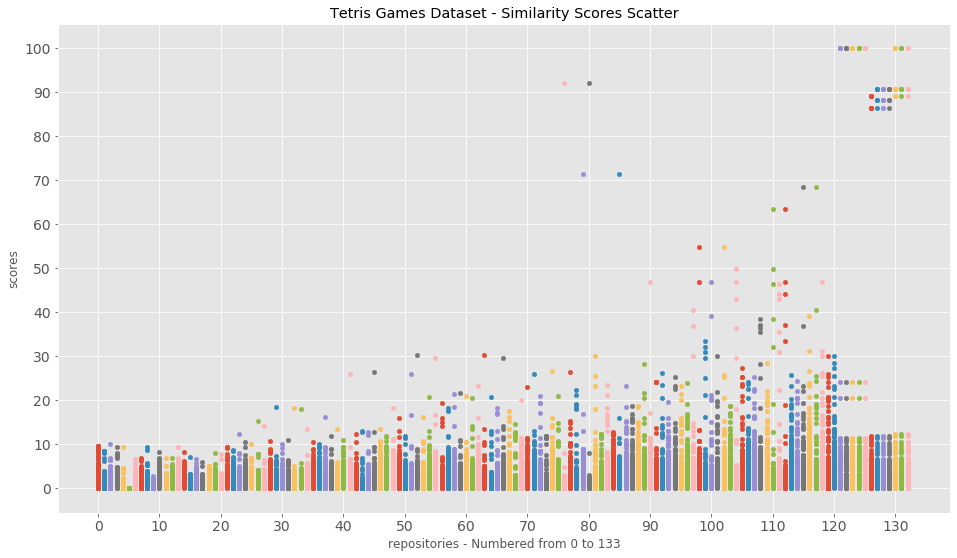

In [269]:
similarity_scatter(df_similarity,"Tetris Games")

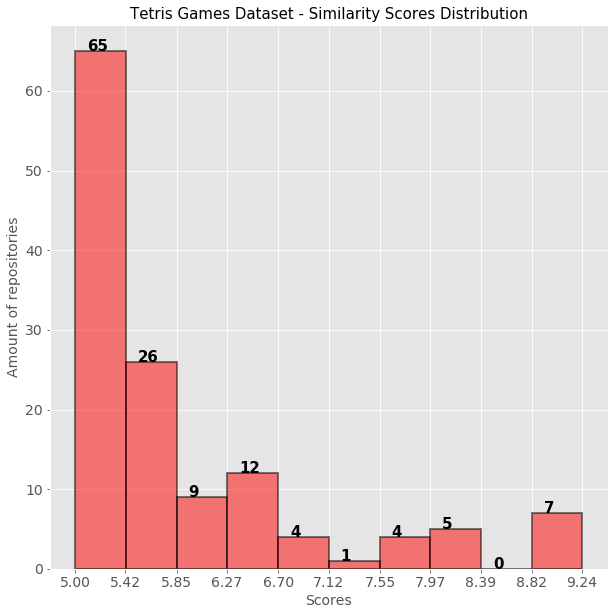

In [270]:
histogram(df_similarity["score"], title="Tetris Games Dataset - Similarity Scores Distribution", 
          face_color='red', text_offset=0.1,bins_amount=BINS_AMOUNT)

### Quality dataset

In [295]:
df_quality = pd.read_excel("tetrisgames_repositories.xlsx")
df_quality = calculate_quality_score(df_quality) # calculate quality
df_quality

12.0 16.0 2.0 7.0


,repo_id,name,owner,forks_url,description,language,forks_count,stargazers_count,watchers_count,size,open_issues_count,has_wiki,pushed_at,created_at,updated_at,subscribers_count,license,html_url,issues,score
66,MDEwOlJlcG9zaXRvcnkxMjUzNDQ1OQ==,tetris,kt97679,https://api.github.com/repos/kt97679/tetris/forks,Tetris game implemented in languages I used fo...,Java,43,68,68,99,0,1,12/11/2019 19:10,9/2/2013 7:33,5/13/2020 11:27,2,0,https://github.com/kt97679/tetris,3,100.0
48,MDEwOlJlcG9zaXRvcnk5MjQ0OTk3,Blockinger,vocollapse,https://api.github.com/repos/vocollapse/Blocki...,Tetris clone for Android,Java,115,119,119,55334,14,1,12/3/2019 11:53,4/5/2013 16:07,6/9/2020 20:12,2,"{""key"": ""other"", ""name"": ""Other"", ""spdx_id"": ""...",https://github.com/vocollapse/Blockinger,18,100.0
113,MDEwOlJlcG9zaXRvcnkyMTMzMDcwNQ==,JavaFX-Tetris-Clone,javafx-dev,https://api.github.com/repos/javafx-dev/JavaFX...,JavaFX Tetris game clone written in Java 8,Java,20,33,33,208,0,1,6/30/2014 7:11,6/29/2014 19:37,5/18/2020 14:31,2,0,https://github.com/javafx-dev/JavaFX-Tetris-Clone,0,100.0
81,MDEwOlJlcG9zaXRvcnkxNjcwNDkyMA==,tedroid,dan-zx,https://api.github.com/repos/dan-zx/tedroid/forks,Juego de Tetris para Android con logros y marc...,Java,6,23,23,24640,1,1,9/2/2014 17:24,2/10/2014 18:33,10/11/2017 22:35,2,"{""key"": ""apache-2.0"", ""name"": ""Apache License ...",https://github.com/dan-zx/tedroid,46,100.0
117,MDEwOlJlcG9zaXRvcnkyNTkyMTcwMQ==,nand2tetris-emu,itoshkov,https://api.github.com/repos/itoshkov/nand2tet...,Nand2Tetris Software Suite - hardware simulato...,Java,13,39,39,989,6,1,4/21/2020 12:00,10/29/2014 13:17,5/26/2020 14:27,2,"{""key"": ""gpl-2.0"", ""name"": ""GNU General Public...",https://github.com/itoshkov/nand2tetris-emu,15,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,MDEwOlJlcG9zaXRvcnkxMTMyODI4OTg=,tetris,watermelondududu,https://api.github.com/repos/watermelondududu/...,0,Java,2,0,0,101,0,1,1/11/2018 14:16,12/6/2017 7:21,1/8/2018 5:02,2,0,https://github.com/watermelondududu/tetris,0,0.0
72,MDEwOlJlcG9zaXRvcnkxMzc3NDI1OA==,Tetrist,jerenome,https://api.github.com/repos/jerenome/Tetrist/...,T'es triste,Java,2,0,0,1402,0,1,12/9/2013 9:02,10/22/2013 13:34,12/11/2014 14:36,2,"{""key"": ""other"", ""name"": ""Other"", ""spdx_id"": ""...",https://github.com/jerenome/Tetrist,0,0.0
42,MDEwOlJlcG9zaXRvcnk4MzQwMDcw,Slick2dTetris,betondur,https://api.github.com/repos/betondur/Slick2dT...,0,Java,2,0,0,1316,0,1,2/26/2013 23:09,2/21/2013 17:23,10/21/2013 4:57,2,0,https://github.com/betondur/Slick2dTetris,0,0.0
44,MDEwOlJlcG9zaXRvcnk4NjAyNTgzMw==,tetris-ai,zl1993,https://api.github.com/repos/zl1993/tetris-ai/...,0,Java,2,0,0,84,0,1,4/12/2017 16:52,3/24/2017 4:07,3/24/2017 4:45,2,0,https://github.com/zl1993/tetris-ai,0,0.0


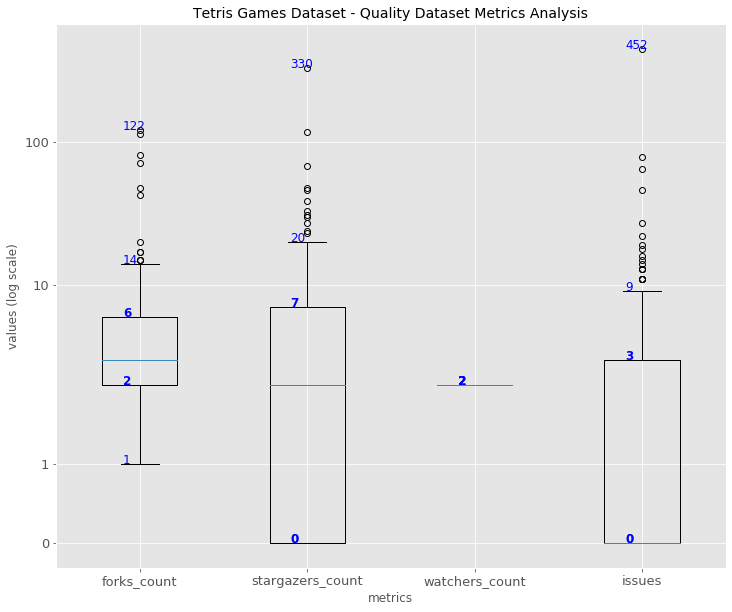

In [301]:
metric_boxplots(df_quality, "Tetris Games Dataset - Quality Dataset Metrics Analysis")

In [273]:
show_insignificants(df_quality, "Tetris-Games")

Total rows in the Tetris-Games dataset: 133


,All row values are less than or equal to,rows
0,0,0
1,1,0
2,2,35
3,3,48
4,4,54
5,5,63
6,6,70
7,7,77
8,8,81
9,9,84


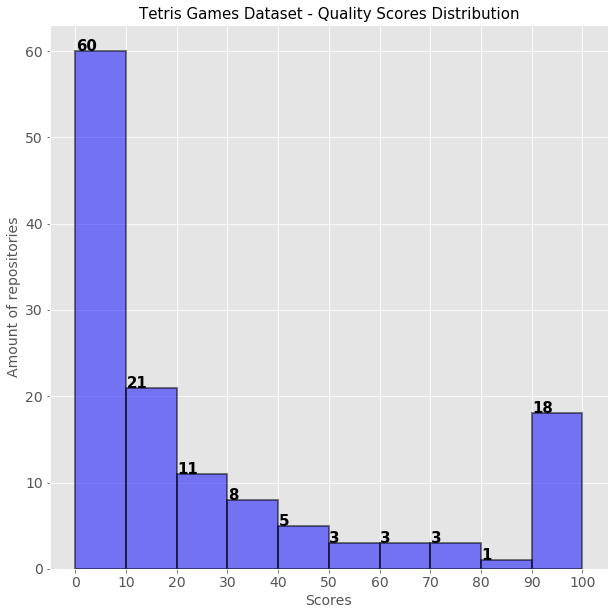

In [274]:
histogram(df_quality["score"], title="Tetris Games Dataset - Quality Scores Distribution", 
          face_color='blue', text_offset=0.1)

### Combine similarity & quality - graph

In [275]:
df_combined = combine_quality_similarity(df_similarity,df_quality)
df_combined

,similarity,quality
repo_id,,
MDEwOlJlcG9zaXRvcnkxNzU0MTcyMDY=,9.24242,8.98042
MDEwOlJlcG9zaXRvcnkyMTEyOTg1OTY=,9.24242,4.18636
MDEwOlJlcG9zaXRvcnkyMTI2MjkzNTg=,9.24242,2.29575
MDEwOlJlcG9zaXRvcnkyMTM3NTA3ODc=,9.09091,1.14787
MDEwOlJlcG9zaXRvcnkyNDMyMTA3NTk=,9.09091,3.37610
...,...,...
MDEwOlJlcG9zaXRvcnkxODMwOTQwMA==,5.00000,26.67117
MDEwOlJlcG9zaXRvcnkxMDA0ODM=,5.00000,25.05064
MDEwOlJlcG9zaXRvcnkxMjkzOTc4OQ==,5.00000,22.55233


,similarity,quality
similarity,1.000000,-0.176434
quality,-0.176434,1.000000


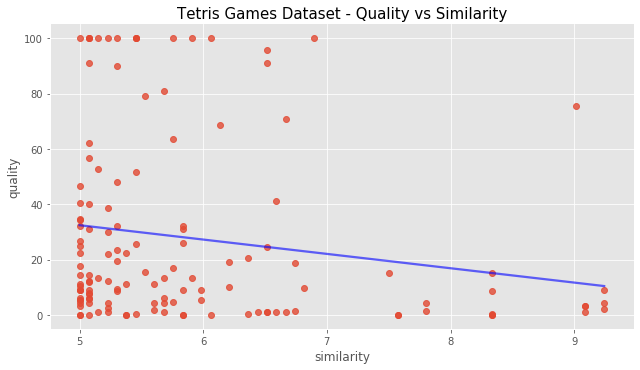

In [276]:
plot_correlation("Tetris Games",df_combined)
df_combined.corr()

## DBManagement  Dataset

### Similarity dataset

In [277]:
df_similarity = pd.read_excel("dbmanagement_similarity_matrix.xlsx",sheet_name=0,index_col=0)
df_similarity = calculate_similarity_scores(df_similarity,bins=BINS_AMOUNT) # calculate similarity
df_similarity

,MDEwOlJlcG9zaXRvcnk0MzI2MTE3MQ==,MDEwOlJlcG9zaXRvcnk0MzYyODQ0Mw==,MDEwOlJlcG9zaXRvcnk0OTg5Njg4MQ==,MDEwOlJlcG9zaXRvcnk2NzQwMDg0OA==,MDEwOlJlcG9zaXRvcnk2NzY0MDYwOQ==,MDEwOlJlcG9zaXRvcnk3MTcwMDU4,MDEwOlJlcG9zaXRvcnk4NDcxNjQyNA==,MDEwOlJlcG9zaXRvcnk4NjE3NjkwMQ==,MDEwOlJlcG9zaXRvcnk4NTc4MjAxNQ==,MDEwOlJlcG9zaXRvcnk4NTUxMTU4Mw==,...,MDEwOlJlcG9zaXRvcnkyNjQ1ODY1NjA=,MDEwOlJlcG9zaXRvcnkyNjY4OTYyMDg=,MDEwOlJlcG9zaXRvcnkyNjYwMDg0MjA=,MDEwOlJlcG9zaXRvcnkyNTA0MTgwNTA=,MDEwOlJlcG9zaXRvcnkyNTA3NjU1NzA=,MDEwOlJlcG9zaXRvcnkyNTg3MTQ0Nw==,MDEwOlJlcG9zaXRvcnkyNTI4MTA2MjI=,MDEwOlJlcG9zaXRvcnkyNTkzMTQ4OTg=,MDEwOlJlcG9zaXRvcnkyNTQwNDQ1MzQ=,score
MDEwOlJlcG9zaXRvcnkxMTY1OTI0NjI=,3.65,8.29,0.67,2.73,5.64,6.24,2.11,4.69,2.68,0.62,...,1.10,2.50,0.66,2.29,81.51,0.05,5.64,1.50,1.20,12.61468
MDEwOlJlcG9zaXRvcnkxMzY3NDc1Mjc=,3.65,8.29,0.67,2.73,5.64,6.24,2.11,4.69,2.68,0.62,...,1.10,2.50,0.66,2.29,81.51,0.05,5.64,1.50,1.20,12.61468
MDEwOlJlcG9zaXRvcnk5OTM1OTU0NQ==,3.65,8.29,0.67,2.73,5.64,6.24,2.11,4.69,2.68,0.62,...,1.10,2.50,0.66,2.29,81.51,0.05,5.64,1.50,1.20,12.61468
MDEwOlJlcG9zaXRvcnkxMDk3MjI4NjE=,3.65,8.29,0.67,2.73,5.64,6.24,2.11,4.69,2.68,0.62,...,1.10,2.50,0.66,2.29,81.51,0.05,5.64,1.50,1.20,12.61468
MDEwOlJlcG9zaXRvcnkxMzM0MTUxMzc=,3.68,8.16,0.35,2.45,4.60,5.98,2.13,4.73,2.26,0.63,...,0.79,2.52,0.67,2.31,82.17,0.05,4.60,1.51,1.21,12.61468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MDEwOlJlcG9zaXRvcnkxMzExNTMzOTI=,6.24,4.33,2.64,4.13,6.81,8.82,0.16,6.55,3.07,3.82,...,4.18,2.84,1.95,0.53,1.72,0.02,6.81,1.13,2.77,5.00000
MDEwOlJlcG9zaXRvcnkxNzExNjE4MQ==,3.72,0.94,8.61,2.46,2.32,1.11,0.60,1.88,1.06,0.45,...,0.79,1.35,0.84,0.40,0.70,0.01,2.32,1.97,1.04,5.00000
MDEwOlJlcG9zaXRvcnkxODk3NTQ5MDc=,1.06,0.56,1.02,2.56,1.78,0.57,0.10,0.32,0.89,1.40,...,0.98,1.30,0.82,0.53,0.30,0.01,1.78,0.46,1.98,5.00000
MDEwOlJlcG9zaXRvcnkxNDQ3NTY3ODk=,1.06,1.07,2.51,1.62,1.38,0.14,0.19,0.38,0.45,0.93,...,0.51,0.52,0.34,0.19,0.71,0.00,1.38,0.67,0.56,5.00000


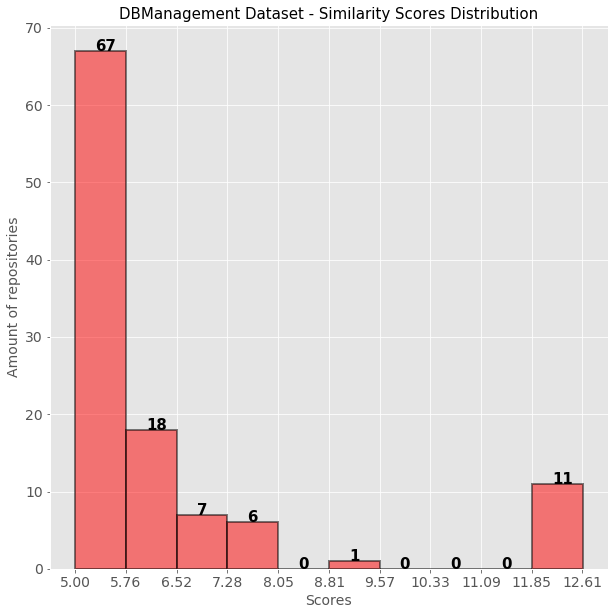

In [278]:
histogram(df_similarity["score"], title="DBManagement Dataset - Similarity Scores Distribution", 
          face_color='red', text_offset=0.3,bins_amount=BINS_AMOUNT)

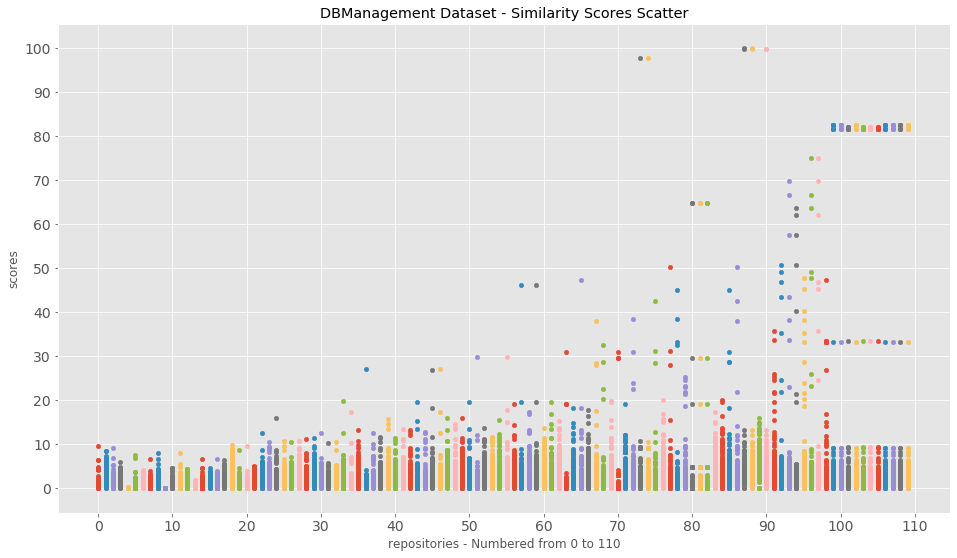

In [279]:
similarity_scatter(df_similarity,"DBManagement")

### Quality dataset

In [303]:
df_quality = pd.read_excel("dbmanagement_repositories.xlsx")
df_quality = calculate_quality_score(df_quality) # calculate quality
df_quality

2.0 5.0 3.0 2.0


,repo_id,name,owner,forks_url,description,language,forks_count,stargazers_count,watchers_count,size,open_issues_count,has_wiki,pushed_at,created_at,updated_at,subscribers_count,license,html_url,issues,score
0,MDEwOlJlcG9zaXRvcnk3MTcwMDU4,flyway,flyway,https://api.github.com/repos/flyway/flyway/forks,Flyway by Redgate • Database Migrations Made E...,Java,1045,5127,5127,15351,179,0,6/4/2020 14:33,12/14/2012 18:43,6/6/2020 14:00,30,"{""key"": ""other"", ""name"": ""Other"", ""spdx_id"": ""...",https://github.com/flyway/flyway,2830,100.0
6,MDEwOlJlcG9zaXRvcnkxMzk0NjgyNzY=,Library-Management-System-JAVA,OSSpk,https://api.github.com/repos/OSSpk/Library-Man...,📚 A sophisticated Library Management System de...,Java,59,64,64,983,2,1,10/9/2019 9:32,7/2/2018 16:35,6/6/2020 8:09,11,"{""key"": ""mit"", ""name"": ""MIT License"", ""spdx_id...",https://github.com/OSSpk/Library-Management-Sy...,3,100.0
11,MDEwOlJlcG9zaXRvcnkyNTQwNDQ1MzQ=,openjfx-database,GZYangKui,https://api.github.com/repos/GZYangKui/openjfx...,The openjfx-database repo has moved to:,Java,3,21,21,59230,0,1,5/22/2020 2:44,4/8/2020 9:33,5/22/2020 3:33,2,"{""key"": ""apache-2.0"", ""name"": ""Apache License ...",https://github.com/GZYangKui/openjfx-database,7,100.0
10,MDEwOlJlcG9zaXRvcnkxNDAxODI0MDk=,AndroidEasySQL-Library,p32929,https://api.github.com/repos/p32929/AndroidEas...,An Easier & Lazier approach to SQL database fo...,Java,5,23,23,2865,0,1,5/2/2020 3:04,7/8/2018 16:01,5/30/2020 15:02,5,"{""key"": ""mit"", ""name"": ""MIT License"", ""spdx_id...",https://github.com/p32929/AndroidEasySQL-Library,5,100.0
9,MDEwOlJlcG9zaXRvcnk2NzQwMDg0OA==,react-java-goos,jiangxy,https://api.github.com/repos/jiangxy/react-jav...,配合React通用后台的小工具，自动生成后端接口,Java,14,39,39,9108,1,1,4/1/2017 6:03,9/5/2016 8:08,5/17/2020 14:43,6,"{""key"": ""apache-2.0"", ""name"": ""Apache License ...",https://github.com/jiangxy/react-java-goos,2,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,MDEwOlJlcG9zaXRvcnkxMTY1OTI0NjI=,Register-your-customers-interactively,RITUait,https://api.github.com/repos/RITUait/Register-...,An Android Application that takes data interac...,Java,0,0,0,522,0,1,1/8/2018 7:02,1/7/2018 19:22,6/10/2018 7:34,2,0,https://github.com/RITUait/Register-your-custo...,0,0.0
77,MDEwOlJlcG9zaXRvcnkxMzA4NjAzNzU=,Java,furkantekke,https://api.github.com/repos/furkantekke/Java/...,Java Examples,Java,0,0,0,17,0,1,7/3/2019 10:43,4/24/2018 13:41,7/3/2019 10:43,2,0,https://github.com/furkantekke/Java,0,0.0
78,MDEwOlJlcG9zaXRvcnkxMzEyNjQ3NzE=,BCNF-Decomposition,ak1132,https://api.github.com/repos/ak1132/BCNF-Decom...,A driver program to decompose a relation with ...,Java,0,0,0,11,0,1,5/30/2020 0:47,4/27/2018 7:55,5/30/2020 0:47,2,0,https://github.com/ak1132/BCNF-Decomposition,0,0.0
79,MDEwOlJlcG9zaXRvcnkxMzkzMjMyMTQ=,Music-Database-Desktop,Bennyhwanggggg,https://api.github.com/repos/Bennyhwanggggg/Mu...,Song-Album-Artist Database Record Desktop Appl...,Java,0,0,0,6705,0,1,7/1/2018 11:29,7/1/2018 11:25,6/30/2019 7:20,0,0,https://github.com/Bennyhwanggggg/Music-Databa...,0,0.0


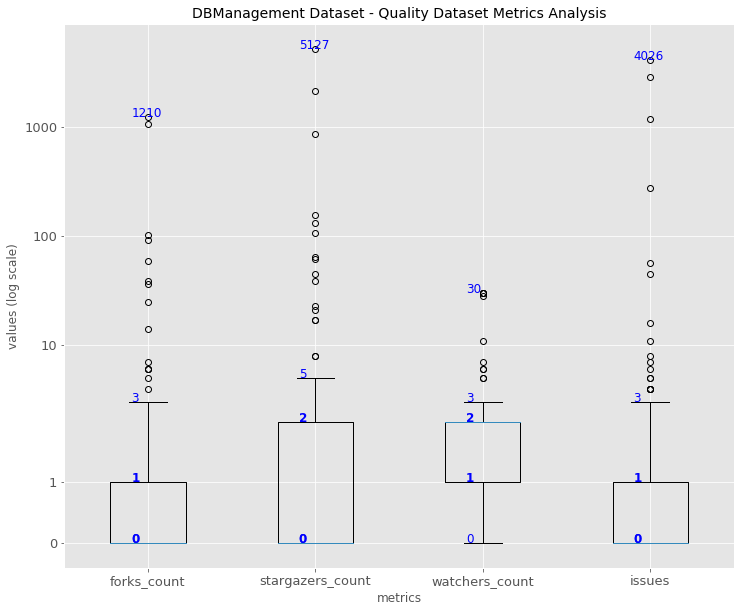

In [304]:
metric_boxplots(df_quality, "DBManagement Dataset - Quality Dataset Metrics Analysis")

In [282]:
show_insignificants(df_quality, "DBManagement")

Total rows in the DBManagement dataset: 111


,All row values are less than or equal to,rows
0,0,4
1,1,17
2,2,78
3,3,82
4,4,85
5,5,90
6,6,92
7,7,93
8,8,95
9,9,95


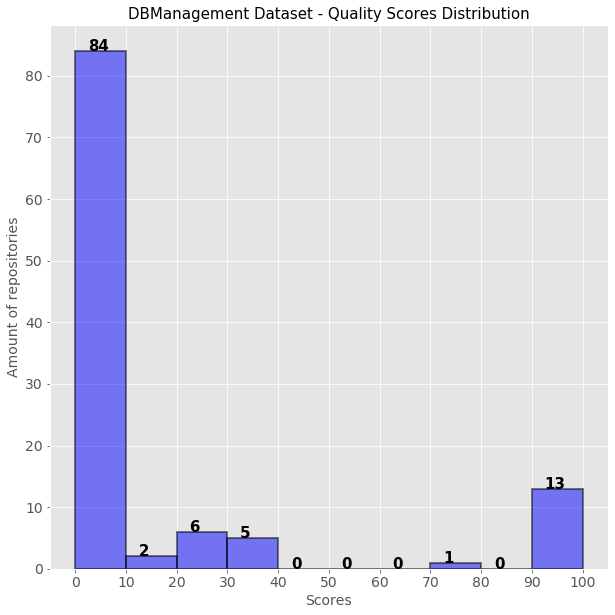

In [283]:
histogram(df_quality["score"], title="DBManagement Dataset - Quality Scores Distribution", 
          face_color='blue', text_offset=2.5)

### Combine similarity & quality - graph

In [284]:
df_combined = combine_quality_similarity(df_similarity,df_quality)
df_combined

,similarity,quality
repo_id,,
MDEwOlJlcG9zaXRvcnkxMTY1OTI0NjI=,12.61468,0.00000
MDEwOlJlcG9zaXRvcnkxMzY3NDc1Mjc=,12.61468,0.00000
MDEwOlJlcG9zaXRvcnk5OTM1OTU0NQ==,12.61468,4.13502
MDEwOlJlcG9zaXRvcnkxMDk3MjI4NjE=,12.61468,0.00000
MDEwOlJlcG9zaXRvcnkxMzM0MTUxMzc=,12.61468,0.00000
...,...,...
MDEwOlJlcG9zaXRvcnkxMzExNTMzOTI=,5.00000,8.24191
MDEwOlJlcG9zaXRvcnkxNzExNjE4MQ==,5.00000,100.00000
MDEwOlJlcG9zaXRvcnkxODk3NTQ5MDc=,5.00000,29.76090


,similarity,quality
similarity,1.00000,-0.00797
quality,-0.00797,1.00000


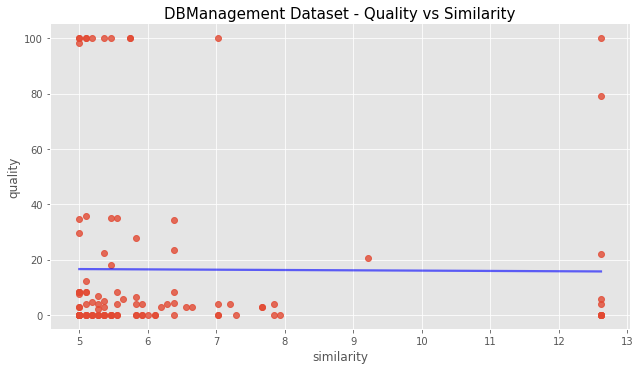

In [285]:
plot_correlation("DBManagement",df_combined)
df_combined.corr()

## Operating Systems Dataset

### Similarity dataset

In [286]:
df_similarity = pd.read_excel("operatingsystems_similarity_matrix.xlsx",sheet_name=0,index_col=0)
df_similarity = calculate_similarity_scores(df_similarity,bins=BINS_AMOUNT) # calculate similarity
df_similarity

,MDEwOlJlcG9zaXRvcnk2Mjk5OTMxOA==,MDEwOlJlcG9zaXRvcnk2OTAyNDg1MQ==,MDEwOlJlcG9zaXRvcnk3Mjk4NjUyOA==,MDEwOlJlcG9zaXRvcnk3Mzk1Nzc3NA==,MDEwOlJlcG9zaXRvcnk3NzM5Nzc3Mw==,MDEwOlJlcG9zaXRvcnk3ODkzODg1MA==,MDEwOlJlcG9zaXRvcnk4MjYxMTI5OA==,MDEwOlJlcG9zaXRvcnk4MTg3MzIyOQ==,MDEwOlJlcG9zaXRvcnk4MTI4MTgzMQ==,MDEwOlJlcG9zaXRvcnk4MzAwMDY3OQ==,...,MDEwOlJlcG9zaXRvcnkyMzUyNzQ4NjU=,MDEwOlJlcG9zaXRvcnkyMzUzNjg2NDE=,MDEwOlJlcG9zaXRvcnkyNDg0MjczMjk=,MDEwOlJlcG9zaXRvcnkyNjExMDI0Nzk=,MDEwOlJlcG9zaXRvcnkyNjI1Mjk2NA==,MDEwOlJlcG9zaXRvcnkyNTE2MjYyMjI=,MDEwOlJlcG9zaXRvcnkyNTY5Mjg5ODQ=,MDEwOlJlcG9zaXRvcnkyOTg2MDQ2Mw==,MDEwOlJlcG9zaXRvcnkzNDEyMDE0MA==,score
MDEwOlJlcG9zaXRvcnkyNjExMDI0Nzk=,0.52,0.29,0.31,4.74,32.83,1.26,0.55,0.72,1.16,0.26,...,0.62,1.37,3.57,100.00,0.37,0.97,4.44,0.96,2.56,7.10526
MDEwOlJlcG9zaXRvcnkxODAyNDEwNjc=,2.09,0.75,0.89,5.37,32.51,2.04,0.97,1.68,0.78,0.65,...,2.06,3.66,2.65,66.19,3.24,7.89,5.09,2.01,4.79,7.00000
MDEwOlJlcG9zaXRvcnkxMzIwMTg2MDU=,5.78,1.82,1.38,5.05,15.43,2.69,3.25,3.50,1.10,1.60,...,2.84,8.19,4.13,14.81,1.53,4.79,7.69,3.46,10.53,6.78947
MDEwOlJlcG9zaXRvcnk3NzM5Nzc3Mw==,0.81,0.49,0.55,4.98,100.00,2.18,1.69,3.10,2.51,0.67,...,1.83,3.49,8.39,32.83,0.63,6.34,7.71,2.02,3.72,6.78947
MDEwOlJlcG9zaXRvcnkyMTU4Mjg0NjM=,1.28,1.20,2.07,3.98,22.37,1.95,0.97,0.38,3.88,1.48,...,1.29,3.94,0.80,51.77,2.00,0.22,4.08,1.77,2.24,6.78947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MDEwOlJlcG9zaXRvcnkxMTM4MTQyNjk=,0.48,0.28,0.34,3.90,3.16,1.15,0.43,0.17,0.22,1.45,...,0.68,0.69,1.71,1.40,1.04,0.94,1.59,0.92,1.49,5.00000
MDEwOlJlcG9zaXRvcnkxNjM3OTg5MDA=,1.16,1.22,0.28,0.24,0.09,0.75,0.46,0.38,0.35,0.44,...,1.19,0.44,0.36,0.11,2.35,1.24,1.41,0.23,2.01,5.00000
MDEwOlJlcG9zaXRvcnkxMjc2NDI5OTg=,1.53,1.51,0.78,1.03,0.85,2.16,4.25,0.11,0.34,1.37,...,0.90,5.09,0.61,0.60,1.90,0.10,1.50,2.22,1.16,5.00000
MDEwOlJlcG9zaXRvcnk5MDU2Nzc3Mw==,7.54,0.96,0.43,1.53,3.72,1.94,1.54,1.31,2.02,0.57,...,1.82,2.65,3.15,2.29,0.49,2.66,2.78,2.16,4.03,5.00000


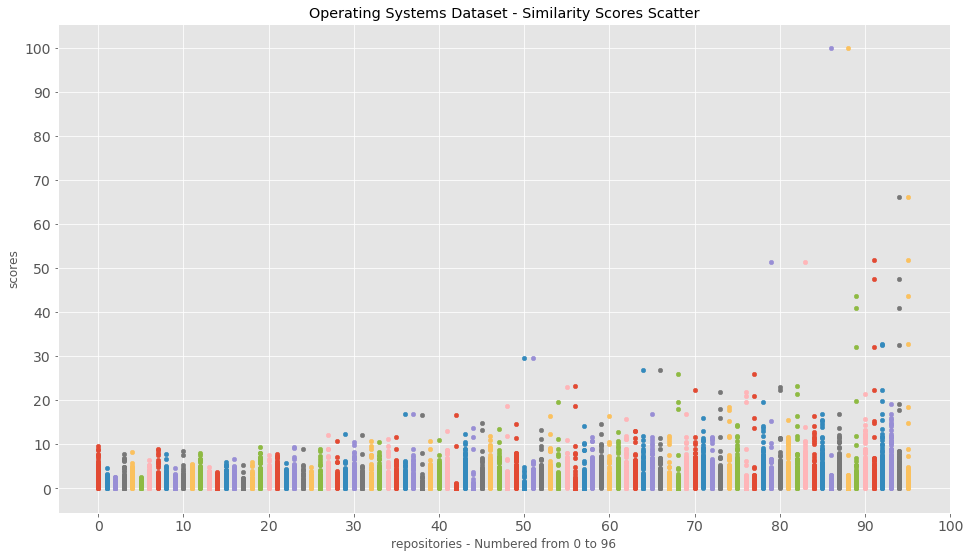

In [287]:
similarity_scatter(df_similarity,"Operating Systems")

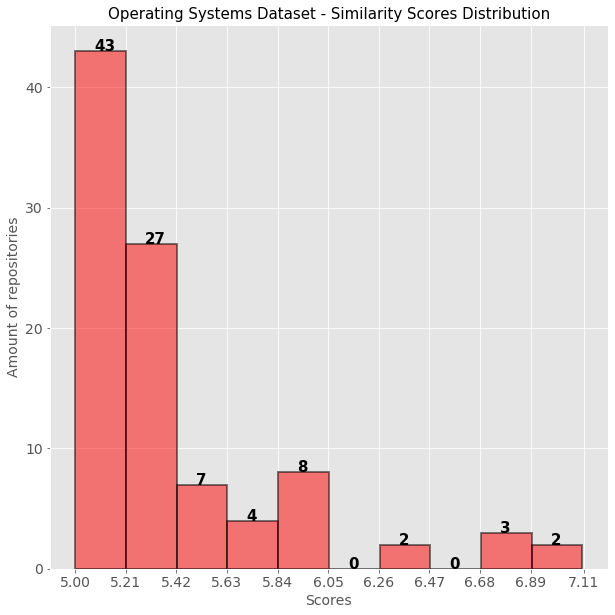

In [288]:
histogram(df_similarity["score"], title="Operating Systems Dataset - Similarity Scores Distribution", 
          face_color='red', text_offset=0.08,bins_amount=BINS_AMOUNT)

### Quality dataset

In [305]:
df_quality = pd.read_excel("operatingsystems_repositories.xlsx")
df_quality = calculate_quality_score(df_quality) # calculate quality
df_quality

2.0 2.0 3.0 1.0


,repo_id,name,owner,forks_url,description,language,forks_count,stargazers_count,watchers_count,size,open_issues_count,has_wiki,pushed_at,created_at,updated_at,subscribers_count,license,html_url,issues,score
0,MDEwOlJlcG9zaXRvcnkzNDA3MTE0,oshi,oshi,https://api.github.com/repos/oshi/oshi/forks,Native Operating System and Hardware Information,Java,432,1631,1631,162286,6,1,6/10/2020 6:01,2/10/2012 12:46,6/10/2020 14:48,30,"{""key"": ""mit"", ""name"": ""MIT License"", ""spdx_id...",https://github.com/oshi/oshi,1241,100.0
17,MDEwOlJlcG9zaXRvcnkxMTY2NzIxMzU=,TIL,KSH-code,https://api.github.com/repos/KSH-code/TIL/forks,공부한 내용에 대해서 정리 합니다.,Java,0,5,5,1285,0,1,10/26/2018 8:49,1/8/2018 12:09,4/12/2020 6:15,0,0,https://github.com/KSH-code/TIL,7,100.0
3,MDEwOlJlcG9zaXRvcnkxNDIyMDU1MjE=,CPU-Scheduler,brilacasck,https://api.github.com/repos/brilacasck/CPU-Sc...,simulating scheduling algorithms of operating ...,Java,2,10,10,985,0,1,7/31/2018 13:19,7/24/2018 19:45,6/4/2020 5:18,3,"{""key"": ""mit"", ""name"": ""MIT License"", ""spdx_id...",https://github.com/brilacasck/CPU-Scheduler,1,100.0
4,MDEwOlJlcG9zaXRvcnkxNDQ2MTc5NDU=,OperatingSystemScheduling,AhmadYahya97,https://api.github.com/repos/AhmadYahya97/Oper...,Operating Systems project - Processes scheduli...,Java,2,8,8,499,0,1,3/23/2019 11:12,8/13/2018 18:24,5/11/2020 12:14,1,0,https://github.com/AhmadYahya97/OperatingSyste...,1,100.0
5,MDEwOlJlcG9zaXRvcnkxMDg1NTM4MDI=,Operating-System-Algorithms,Showndarya,https://api.github.com/repos/Showndarya/Operat...,"Process synchronization, Deadlock avoidance an...",Java,2,2,2,11,0,1,11/2/2018 5:57,10/27/2017 14:06,11/21/2019 4:17,1,0,https://github.com/Showndarya/Operating-System...,1,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,MDEwOlJlcG9zaXRvcnkxMjk0NjA3OTg=,Nachos-CSE306,msafari,https://api.github.com/repos/msafari/Nachos-CS...,NACHOS Operating System project - SBU,Java,0,0,0,505,0,1,4/13/2018 22:42,4/13/2018 22:41,4/13/2018 22:52,0,"{""key"": ""other"", ""name"": ""Other"", ""spdx_id"": ""...",https://github.com/msafari/Nachos-CSE306,0,0.0
67,MDEwOlJlcG9zaXRvcnkxMTE0NTU0OTk=,OS-simulator,soumik1998,https://api.github.com/repos/soumik1998/OS-sim...,Java based GUI to simulate various common algo...,Java,0,0,0,136,0,1,11/20/2017 19:55,11/20/2017 19:47,11/20/2017 19:57,2,0,https://github.com/soumik1998/OS-simulator,0,0.0
68,MDEwOlJlcG9zaXRvcnkxMTg4NzQ5NjQ=,nachOS-priority-threads-scheduling-algorithm,JackyC415,https://api.github.com/repos/JackyC415/nachOS-...,Nachos Operating System design and implementation,Java,0,0,0,256,0,1,5/17/2018 5:27,1/25/2018 6:54,7/3/2018 5:31,2,0,https://github.com/JackyC415/nachOS-priority-t...,0,0.0
69,MDEwOlJlcG9zaXRvcnkxMTM1NDQyNDM=,CSI3131,flsing,https://api.github.com/repos/flsing/CSI3131/forks,Operating Systems,Java,0,0,0,1124,0,1,4/17/2018 7:27,12/8/2017 7:17,4/17/2018 7:35,1,0,https://github.com/flsing/CSI3131,0,0.0


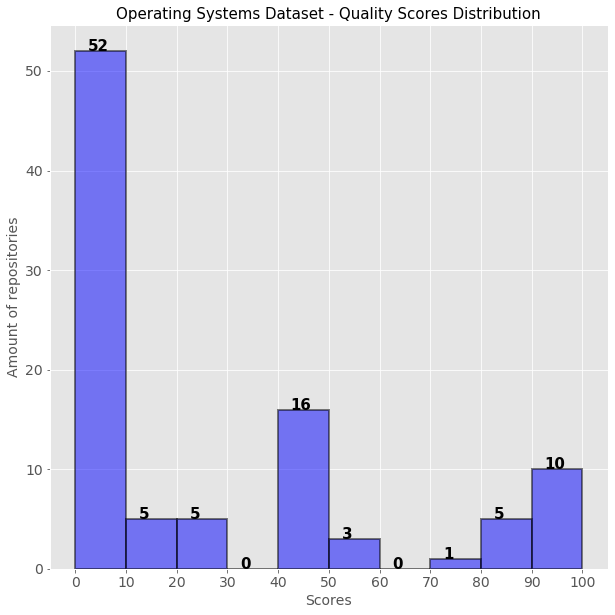

In [306]:
histogram(df_quality["score"], title="Operating Systems Dataset - Quality Scores Distribution", 
          face_color='blue', text_offset=2.5)

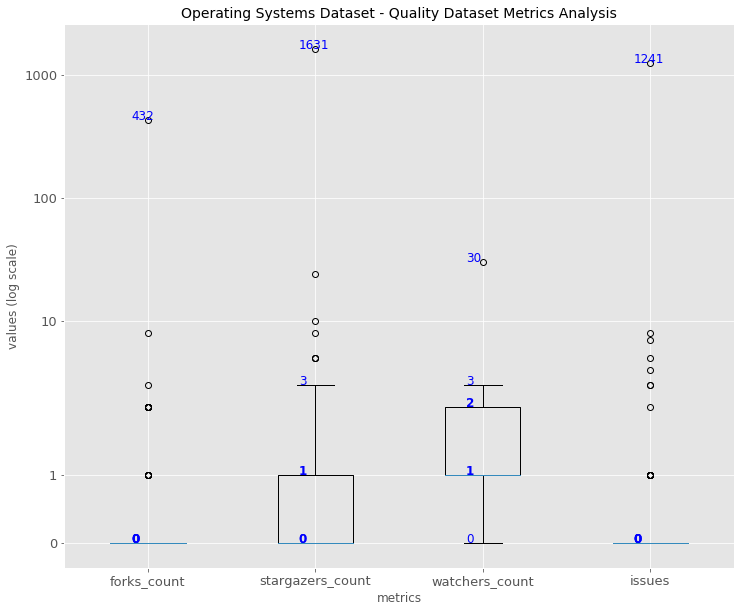

In [307]:
metric_boxplots(df_quality, "Operating Systems Dataset - Quality Dataset Metrics Analysis")

In [292]:
show_insignificants(df_quality, "Operating Systems")

Total rows in the Operating Systems dataset: 97


,All row values are less than or equal to,rows
0,0,10
1,1,39
2,2,82
3,3,88
4,4,89
5,5,92
6,6,92
7,7,93
8,8,94
9,9,94


### Combine similarity & quality - graph

In [293]:
df_combined = combine_quality_similarity(df_similarity,df_quality)
df_combined

,similarity,quality
repo_id,,
MDEwOlJlcG9zaXRvcnkyNjExMDI0Nzk=,7.10526,0.00000
MDEwOlJlcG9zaXRvcnkxODAyNDEwNjc=,7.00000,0.00000
MDEwOlJlcG9zaXRvcnkxMzIwMTg2MDU=,6.78947,43.67816
MDEwOlJlcG9zaXRvcnk3NzM5Nzc3Mw==,6.78947,43.67816
MDEwOlJlcG9zaXRvcnkyMTU4Mjg0NjM=,6.78947,0.00000
...,...,...
MDEwOlJlcG9zaXRvcnkxMTM4MTQyNjk=,5.00000,56.44955
MDEwOlJlcG9zaXRvcnkxNjM3OTg5MDA=,5.00000,0.00000
MDEwOlJlcG9zaXRvcnkxMjc2NDI5OTg=,5.00000,0.00000


,similarity,quality
similarity,1.000000,-0.111519
quality,-0.111519,1.000000


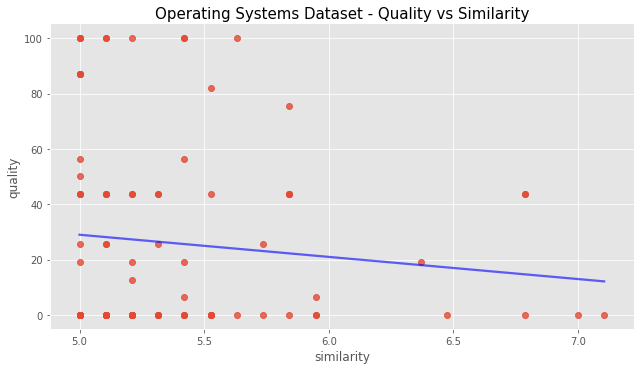

In [294]:
plot_correlation("Operating Systems",df_combined)
df_combined.corr()